In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_custom_graph(nodes, edges, pos=None, title="Graph", bitstring=None):
    """
    Draws a graph with a given set of nodes, edges, and optional positions and bitstring coloring.

    Parameters:
    - nodes: list of node indices (e.g., [0, 1, 2, 3, 4])
    - edges: list of edge tuples (e.g., [(0, 1), (0, 2)])
    - pos: dict of node positions {node: (x, y)}, optional
    - title: title of the plot
    - bitstring: optional string of '0' and '1' used to color nodes and cut edges
    """
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    if pos is None:
        pos = nx.circular_layout(G)

    # Set default color maps
    color_map = ['lightblue'] * len(nodes)
    edge_colors = ['gray'] * len(edges)

    # If bitstring is provided, assign node and edge colors
    if bitstring:
        bitstring = bitstring[::-1]  # Flip due to Qiskit's little-endian format
        color_map = ['green' if bitstring[node] == '1' else 'lightgray' for node in nodes]
        edge_colors = [
            'green' if bitstring[i] != bitstring[j] else 'gray'
            for (i, j) in edges
        ]

    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos, with_labels=True, node_color=color_map, edge_color=edge_colors,
        node_size=1200, font_size=16, width=3
    )
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

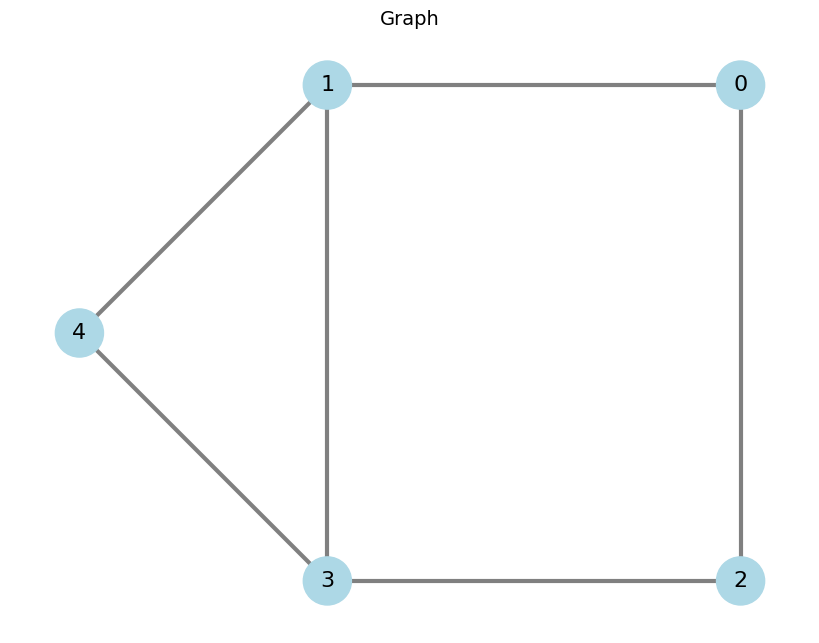

In [2]:
# Example usage:
nodes = [0, 1, 2, 3, 4]
edges = [(0, 1), (0, 2), (1, 3), (1, 4), (2, 3), (3, 4)]
custom_pos = {
    0: (1, 1),
    1: (-1, 1),
    2: (1, -1),
    3: (-1, -1),
    4: (-2.2, 0)
}
draw_custom_graph(nodes, edges, pos=custom_pos, title="Graph")

C:\Users\galda\AppData\Local\Temp\ipykernel_28332\4026036814.py:34: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Most likely bitstring: 01001


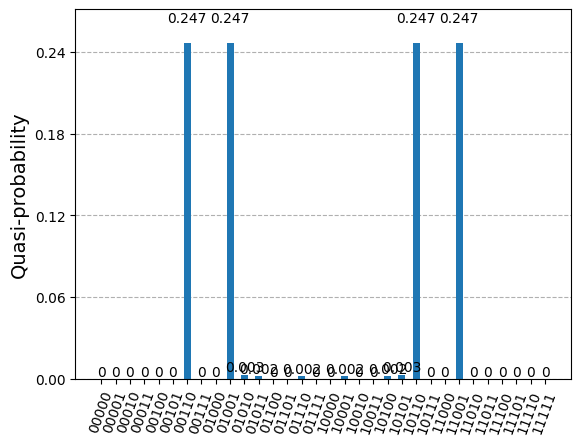

In [3]:
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram

# Define the graph
n = 5
edges = [(0, 1), (0, 2), (1, 3), (1, 4), (2, 3), (3, 4)]

# Parameters for simulation
T = 10               # total evolution time
N_steps = 50        # number of steps
dt = T / N_steps

# Build the circuit
qc = QuantumCircuit(n)
qc.h(range(n))  # initial |+> state

for k in range(1, N_steps + 1):
    s = k / N_steps
    angle_x = 2 * (1 - s) * dt
    angle_zz = -2 * s * dt

    for i, j in edges:
        qc.rzz(angle_zz, i, j) # e^{-i H_C dt}

    for q in range(n):
        qc.rx(angle_x, q) # e^{-i H_B dt}



qc.measure_all()

# Run using the modern Sampler
sampler = Sampler()
result = sampler.run(qc).result()
counts = result.quasi_dists[0].binary_probabilities()

# Display the most likely solutions and histogram
print("Most likely bitstring:", max(counts, key=counts.get))
plot_histogram(counts)


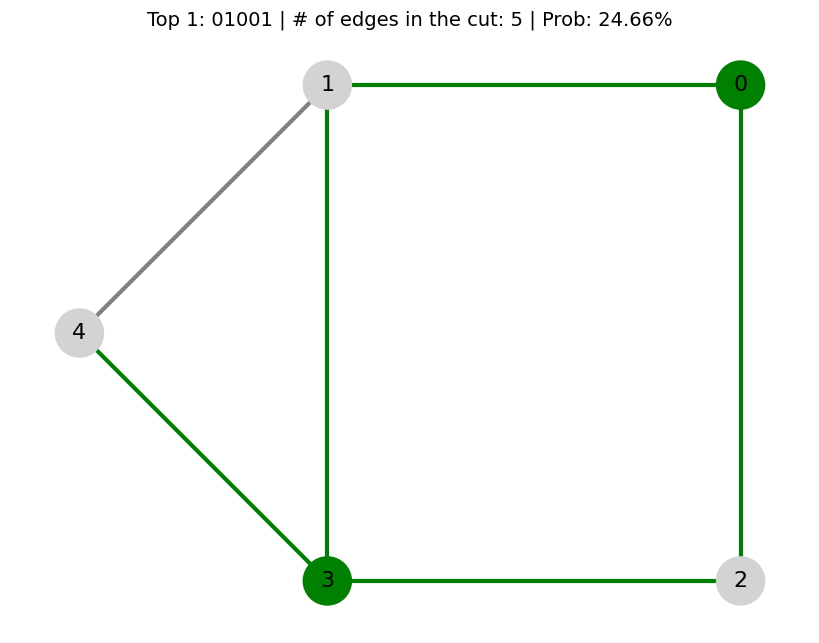

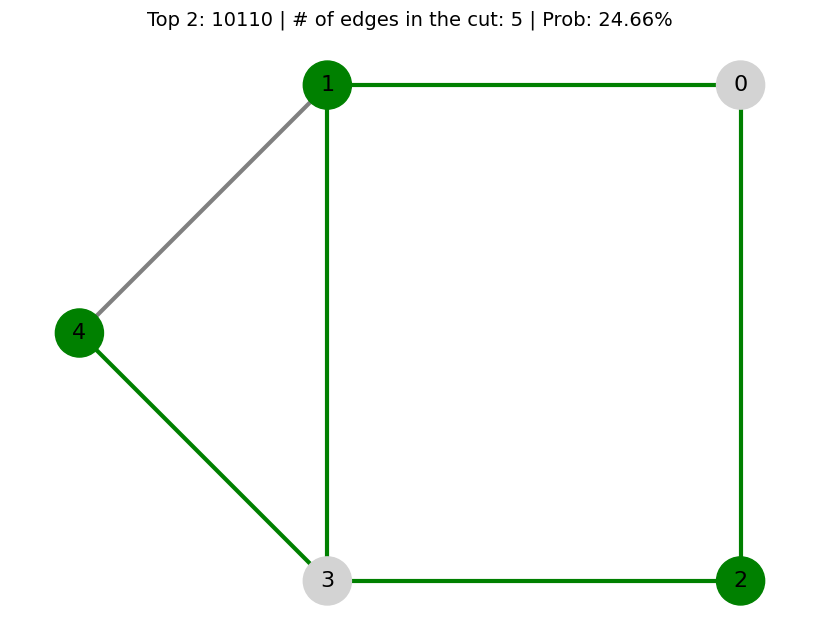

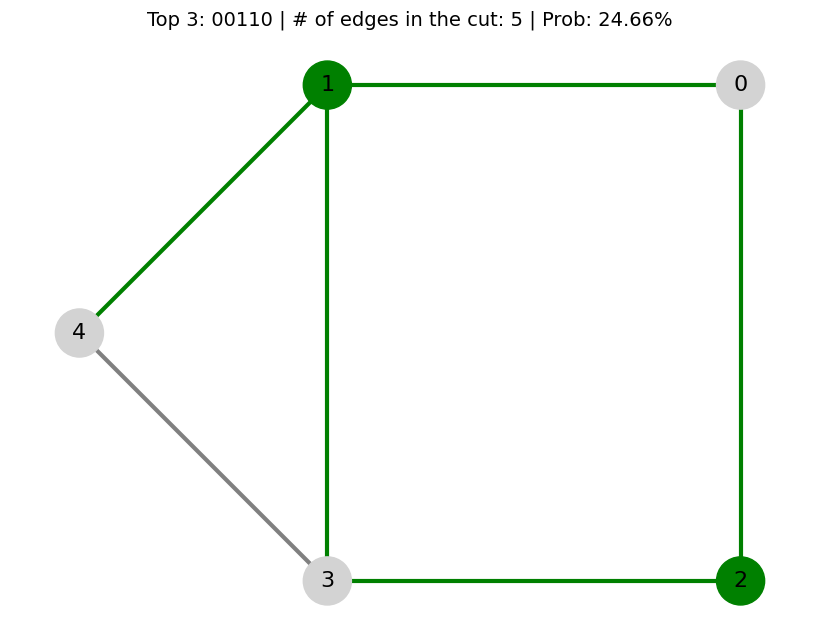

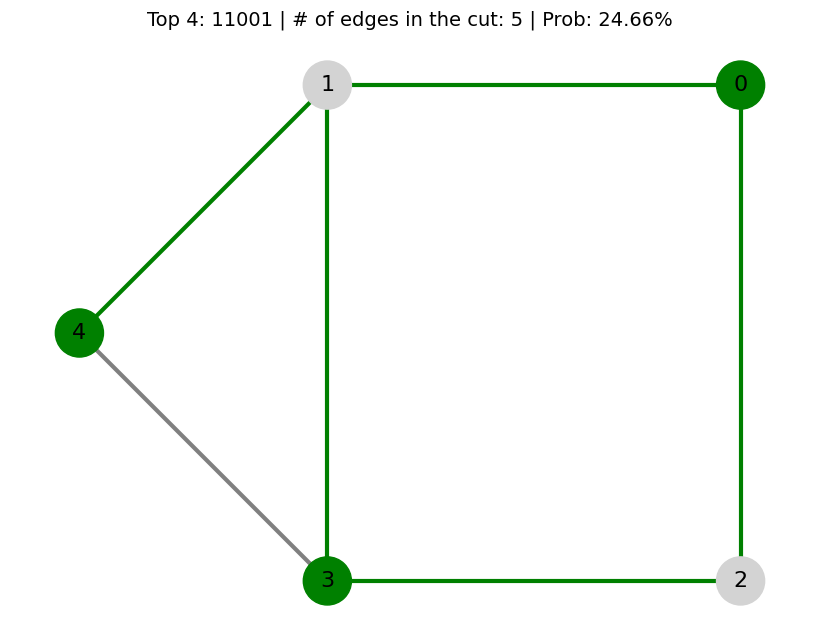

In [4]:
# Sort the results by probability in descending order
sorted_results = sorted(counts.items(), key=lambda item: item[1], reverse=True)

# Get the top 4 most probable bitstrings
top_4 = sorted_results[:4]
# Count cut edges
def count_cut_edges(edges, bitstring):
    bitstring = bitstring[::-1]
    return sum(1 for i, j in edges if bitstring[i] != bitstring[j])

# Plot top 4 with cut edge info
for i, (bitstring, prob) in enumerate(top_4, start=1):
    cut_count = count_cut_edges(edges, bitstring)
    title = f"Top {i}: {bitstring} | # of edges in the cut: {cut_count} | Prob: {prob:.2%}"
    draw_custom_graph(nodes, edges, pos=custom_pos, title=title, bitstring=bitstring)